<a href="https://colab.research.google.com/github/AdityaGogoi/Fast-AI-Deep-Learning/blob/master/Lesson3_CNN_Regression_with_BIWI_Head_pose_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

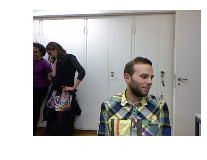

In [8]:
img = open_image(path/fname)
img.show()

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

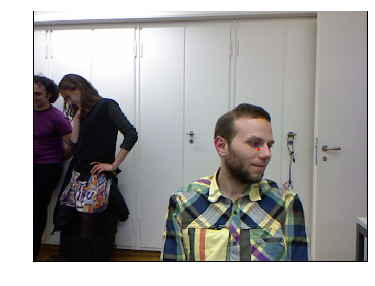

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

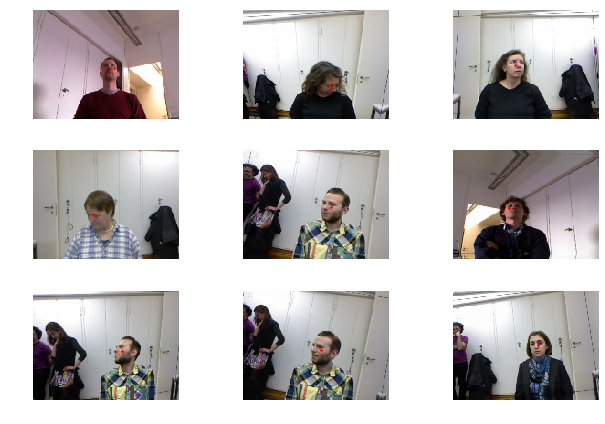

In [14]:
data.show_batch(3, figsize=(9,6))

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


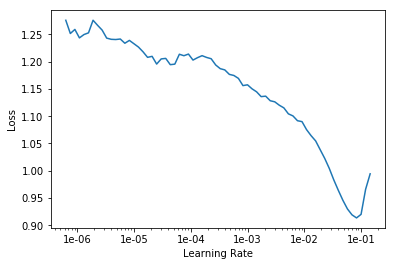

In [16]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [20]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.070443,0.001891,02:49
1,0.028594,0.003434,02:49
2,0.010781,0.002873,02:49
3,0.006231,0.000750,02:46
4,0.004643,0.000715,02:47
5,0.003097,0.000596,02:43
6,0.002222,0.000346,02:40
7,0.001811,0.000790,02:38
8,0.001393,0.000229,02:37
9,0.001217,0.000321,02:39


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

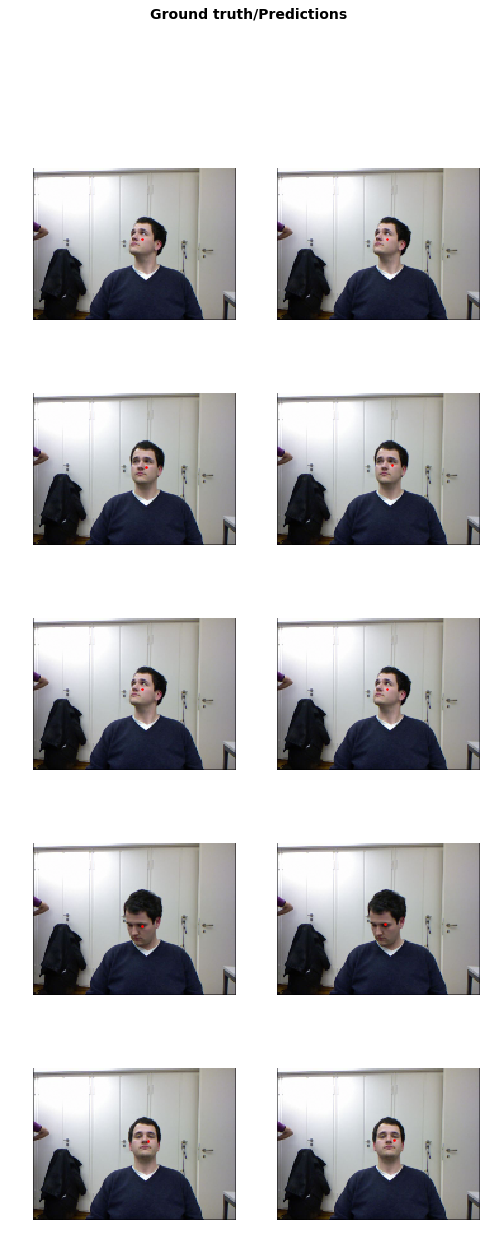

In [23]:
learn.show_results()

## Data augmentation

According to the documentation on [Vision Transforms](https://docs.fast.ai/vision.transform.html):

```max_zoom: if not 1. or less, a random zoom betweem 1. and max_zoom is applied with probability p_affine```

As we cannot have random sizes in the CNN Learner as it throws a PyTorch error related to indices having unequal sizes, we will have to limit the max_zoom to 1.

```Sizes of tensors must match except in dimension 0. Got 1 and 0 in dimension 1 at /pytorch/aten/src/TH/generic/THTensor.cpp:711```

In [72]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
# test_path = Path(base_dir + 'data/HeadPoseImages/renamed')
# test_path.mkdir(parents=True, exist_ok=True)

In [0]:
# test = PointsItemList.from_folder(test_path)

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

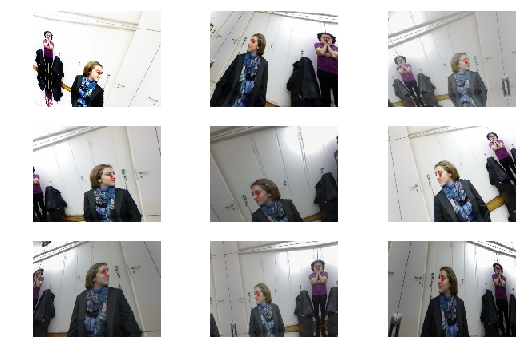

In [49]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(9,6))

## Note

The notebook just **ended at this step**. So I decided to go ahead and use the **augmented dataset** to **train** the model again.

But for some reason, I am getting an **error** while trying to get a **lr_find()** on this dataset.

Also I tried to **research** the **error** but got **answers** only in terms of **size compatibility**, which **does not make sense** as the **size** of all the images are the **same** as before i.e (120, 160).

So for the interest of time, I will only use the **initial learner** and use that in the future sections of this notebook.

In [50]:
learn=None
gc.collect()

14401

In [0]:
# learn = cnn_learner(data, models.resnet34).load('stage-1');
learn = cnn_learner(data, models.resnet34);

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


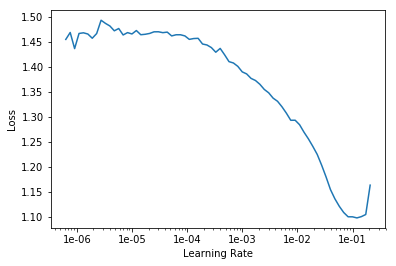

In [53]:
learn.recorder.plot()

For the **validation** of this model, I will use **images** of the **co-workers** in my current project and see if the model is able to locate the **center of their faces**.

But unfortunately, the **model** just keeps **pointing** to the **same point in the image** and **does not** locate the center of their faces.

In [0]:
lr=1e-2

In [55]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,time
0,0.178428,0.009708,02:48
1,0.042746,0.008715,02:48
2,0.025659,0.010886,02:48
3,0.011932,0.001623,02:48
4,0.007499,0.002400,02:49
5,0.005573,0.002310,02:49
6,0.004324,0.001138,02:48
7,0.003565,0.000843,02:48
8,0.002833,0.000389,02:48
9,0.002875,0.000604,02:48


In [0]:
learn.save('stage-2')

In [0]:
learn.load('stage-2');

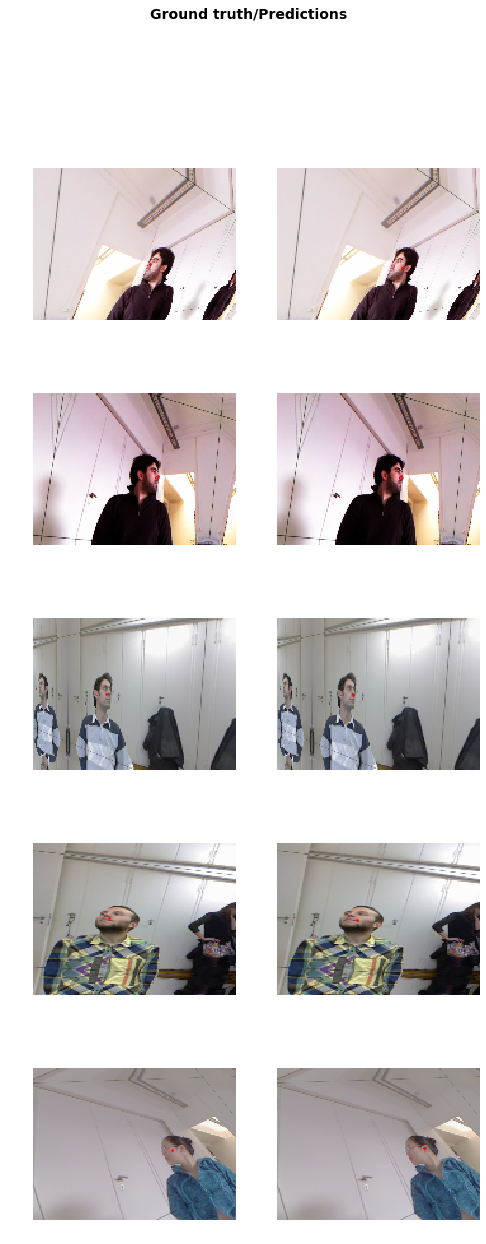

In [64]:
learn.show_results(ds_type=DatasetType.Train)

In [65]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(base_dir + 'data/HeadPoseImages')
path.mkdir(parents=True, exist_ok=True)

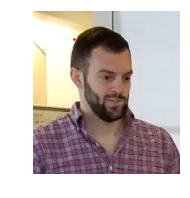

In [67]:
img = open_image(path/'Anthony_1.jpg')
img.show(y=learn.predict(img)[0])

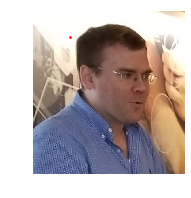

In [68]:
img = open_image(path/'Steve_1.jpg')
img.show(y=learn.predict(img)[0])

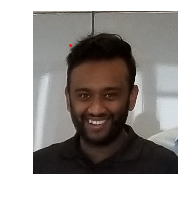

In [69]:
img = open_image(path/'Tanzil_2.jpg')
img.show(y=learn.predict(img)[0])